In [1]:
import pandas as pd
import networkx as nx
import heapq
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities


In [5]:
RATINGS = pd.read_csv('drive/MyDrive/Dataset2/ratings.csv')


In [6]:
RATINGS.head()

,userId,movieId,rating
0,1,440918,2
1,1,41963,2
2,1,16229,5
3,1,1691,4
4,1,245842,5


In [7]:
USERS = RATINGS['userId'].unique().tolist()

In [8]:
print(USERS)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [9]:
SIMILARITY = pd.read_csv('drive/MyDrive/Dataset2/SimilarityOfUsers.csv')
# Clip values to 1.0
SIMILARITY = SIMILARITY.clip(upper=1.0)
# Apply lambda function to replace negative values with 0
SIMILARITY = SIMILARITY.applymap(lambda x: max(0, x))
# Start the row index from 1
SIMILARITY.index = range(1, len(SIMILARITY) + 1)

In [10]:
SIMILARITY.head()

,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
1,1.000000,0.0,0.000000,0.000722,0.002434,0.006505,0.000000,0.005420,0.00001,0.006343,...,0.004075,0.000796,0.000000,0.000000,0.000000,0.000000,0.002447,0.001933,0.000000,0.000000
2,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000646,0.00522,0.000000,...,0.000000,0.000000,0.000000,0.000185,0.020069,0.000000,0.000000,0.000000,0.005510,0.000553
3,0.000000,0.0,1.000000,0.001233,0.000000,0.000000,0.000737,0.000675,0.00000,0.000005,...,0.000000,0.004940,0.000000,0.000000,0.000000,0.016749,0.055044,0.000000,0.003987,0.003113
4,0.000722,0.0,0.001233,1.000000,0.000000,0.000000,0.005089,0.022310,0.00000,0.000000,...,0.000000,0.000000,0.078379,0.000000,0.045734,0.000000,0.000000,0.019796,0.002201,0.001092
5,0.002434,0.0,0.000000,0.000000,1.000000,0.000000,0.000286,0.028647,0.00000,0.003729,...,0.014702,0.000205,0.002235,0.000608,0.000000,0.002953,0.000297,0.006608,0.000000,0.000072


In [11]:
# Restructure similarity matrix into list of tuples
similarity_results = []
for i in range(len(SIMILARITY)):
    for j in range(i+1, len(SIMILARITY)):
        similarity_results.append((i+1, j+1, SIMILARITY.iloc[i, j]))


In [12]:
def model_complex_network(user_nodes, similarity_results, k, p):
    # Create an empty graph
    G = nx.Graph()

    # Add user nodes to the graph
    G.add_nodes_from(user_nodes)

    # Create a dictionary to store similarity results for each user
    similarity_dict = {u: [] for u in user_nodes}
    for (u, v, sim) in similarity_results:
        similarity_dict[u].append((sim, v))
        similarity_dict[v].append((sim, u))

    # Keep track of used similarities to avoid duplicates
    used_similarities = set()

    # Step 1: Add top p similarities for each user
    for u in user_nodes:
        similarities = similarity_dict[u]
        # Get top p similarities for user u
        top_p_similarities = heapq.nlargest(p, similarities)
        for (sim, v) in top_p_similarities:
            if (u, v, sim) not in used_similarities and (v, u, sim) not in used_similarities:
                G.add_edge(u, v, weight=sim)
                used_similarities.add((u, v, sim))
                used_similarities.add((v, u, sim))

    # Step 2: Add remaining (kn - pn) similarities from the remaining similarities
    remaining_similarities = []
    for u in user_nodes:
        for (sim, v) in similarity_dict[u]:
            if (u, v, sim) not in used_similarities and (v, u, sim) not in used_similarities:
                remaining_similarities.append((sim, u, v))

    # Get top (kn - pn) similarities from the remaining similarities
    total_links = k * len(user_nodes)
    already_added_links = G.number_of_edges()
    remaining_links = total_links - already_added_links

    top_remaining_similarities = heapq.nlargest(remaining_links, remaining_similarities)

    for (sim, u, v) in top_remaining_similarities:
        G.add_edge(u, v, weight=sim)

    return G

def plot_network(G):
    H = G

    pos = nx.spring_layout(H, k=0.1, iterations=20)  # positions for all nodes

    # Draw nodes
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(H, pos, node_size=50, node_color='blue', alpha=0.6)

    # Draw edges
    edges = H.edges(data=True)
    weights = [data['weight'] for _, _, data in edges]
    nx.draw_networkx_edges(H, pos, edgelist=edges, width=0.5, alpha=0.5)

    # Draw edge labels (optional, can be commented out for large graphs)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in H.edges(data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_size=6)

    # Draw node labels (optional, can be commented out for large graphs)
    nx.draw_networkx_labels(H, pos, font_size=8, font_family="sans-serif")

    plt.title("Complex Network Based on User Similarities")
    plt.show()

# Example usage:
k = 2
p = 1

network = model_complex_network(USERS, similarity_results, k, p)

# Print edges with weights
for u, v, data in network.edges(data=True):
    print(f"Edge ({u}, {v}) with weight {data['weight']}")



Edge (1, 351) with weight 0.1261311917558945
Edge (2, 516) with weight 0.1142049084522162
Edge (2, 185) with weight 0.1006761415117349
Edge (2, 379) with weight 0.1112920492453573
Edge (2, 557) with weight 0.1031816765902222
Edge (3, 118) with weight 0.1072789349868939
Edge (3, 113) with weight 0.0930126144443982
Edge (4, 159) with weight 0.1172363747787193
Edge (4, 340) with weight 0.094397869789076
Edge (5, 407) with weight 0.182896802877545
Edge (5, 563) with weight 0.1067753284470767
Edge (6, 57) with weight 0.1048461436005856
Edge (6, 82) with weight 0.1018579338315439
Edge (6, 291) with weight 0.0961964577852174
Edge (6, 322) with weight 0.0937848249862128
Edge (7, 158) with weight 0.1216996223664128
Edge (7, 276) with weight 0.118392049948992
Edge (7, 422) with weight 0.1195243881098164
Edge (7, 204) with weight 0.1007995994660005
Edge (7, 596) with weight 0.0946163830147108
Edge (7, 161) with weight 0.0917316059271202
Edge (8, 322) with weight 0.1788244124174631
Edge (8, 350) w

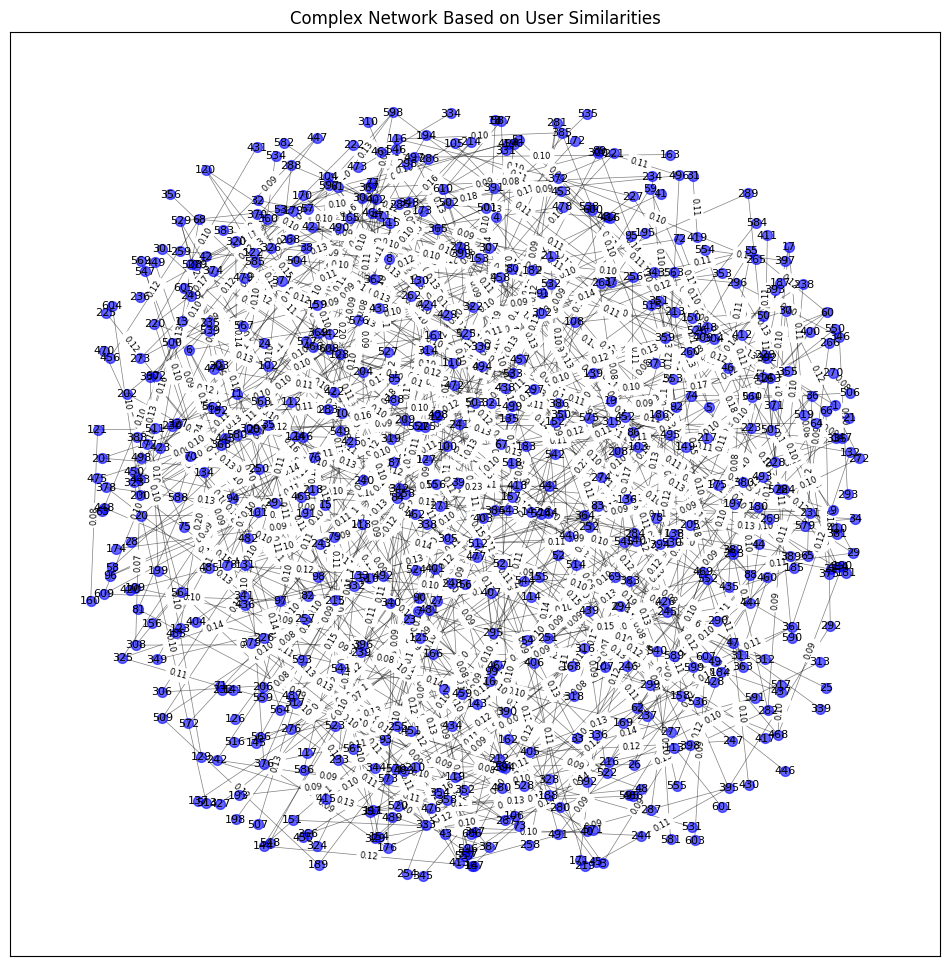

In [13]:
# Plot the network
plot_network(network)

In [15]:
def detect_communities(G):
    # Use the greedy modularity communities method to find communities
    communities = greedy_modularity_communities(G)

    # Convert sets of nodes to lists for easier manipulation
    community_list = [list(community) for community in communities]

    return community_list

def print_communities(communities):
    print(f"Number of clusters: {len(communities)}")
    for i, community in enumerate(communities):
        print(f"\nCluster {i + 1}:")
        print(f"Number of users: {len(community)}")
        print(f"Users: {', '.join(map(str, community))}")

In [16]:
from networkx.algorithms.community.quality import modularity

def calculate_modularity(network, communities):
    # Convert the list of communities to a format accepted by the modularity function
    community_list = [set(community) for community in communities]
    return modularity(network, community_list)

# Detect communities
COMMUNITY = detect_communities(network)

# Print community information
print_communities(COMMUNITY)



Number of clusters: 31

Cluster 1:
Number of users: 48
Users: 132, 518, 393, 521, 10, 272, 405, 281, 28, 417, 418, 39, 168, 169, 556, 301, 49, 306, 180, 183, 440, 569, 570, 189, 62, 452, 72, 328, 76, 206, 209, 339, 472, 218, 605, 94, 223, 99, 356, 231, 361, 107, 237, 243, 247, 251, 509, 510

Cluster 2:
Number of users: 43
Users: 514, 3, 5, 522, 407, 24, 287, 288, 550, 294, 423, 427, 176, 433, 307, 563, 313, 188, 317, 445, 449, 68, 70, 456, 203, 588, 205, 85, 214, 87, 95, 482, 485, 357, 360, 491, 113, 370, 115, 118, 376, 507, 252

Cluster 3:
Number of users: 42
Users: 256, 1, 388, 390, 392, 136, 265, 527, 15, 534, 414, 289, 170, 171, 558, 302, 441, 573, 320, 193, 578, 67, 451, 580, 582, 199, 454, 330, 334, 337, 86, 342, 471, 602, 351, 225, 98, 354, 101, 242, 372, 254

Cluster 4:
Number of users: 41
Users: 129, 386, 387, 389, 267, 141, 144, 401, 404, 21, 149, 535, 283, 156, 285, 540, 167, 425, 177, 561, 312, 314, 318, 448, 69, 325, 453, 581, 202, 333, 592, 338, 82, 467, 345, 477, 93, 226

In [17]:

def communities_to_dataframe(communities):
    # Initialize an empty list to store dictionaries
    rows = []

    # Iterate through the communities
    for i, community in enumerate(communities):
        # Concatenate user IDs into a string
        user_ids = ', '.join(map(str, community))

        # Append cluster number and user IDs as a dictionary
        rows.append({'Cluster Number': i+1, 'User IDs': user_ids})

    # Convert the list of dictionaries into a DataFrame

    df = pd.DataFrame(rows)

    return df

# Convert communities to DataFrame
NETWORK_CLUSTER = communities_to_dataframe(COMMUNITY)
NETWORK_CLUSTER.head(50)

,Cluster Number,User IDs
0,1,"132, 518, 393, 521, 10, 272, 405, 281, 28, 417..."
1,2,"514, 3, 5, 522, 407, 24, 287, 288, 550, 294, 4..."
2,3,"256, 1, 388, 390, 392, 136, 265, 527, 15, 534,..."
3,4,"129, 386, 387, 389, 267, 141, 144, 401, 404, 2..."
4,5,"515, 8, 269, 528, 273, 402, 18, 20, 158, 286, ..."
5,6,"257, 258, 513, 385, 139, 526, 14, 399, 274, 27..."
6,7,"512, 4, 138, 11, 140, 143, 400, 277, 159, 32, ..."
7,8,"194, 196, 261, 135, 264, 9, 329, 394, 270, 207..."
8,9,"391, 263, 142, 529, 146, 153, 157, 293, 296, 4..."
9,10,"517, 137, 395, 13, 22, 23, 27, 413, 544, 545, ..."


In [18]:
def cluster_user_count(communities):
    # Initialize an empty list to store cluster numbers and corresponding user counts
    cluster_user_counts = []

    # Iterate through the communities
    for i, community in enumerate(communities):
        # Get the number of users in the current community
        user_count = len(community)

        # Append cluster number and user count as a tuple
        cluster_user_counts.append((i+1, user_count))

    return cluster_user_counts

# Detect communities

# Get cluster numbers and corresponding user counts
cluster_counts = cluster_user_count(COMMUNITY)

# Create DataFrame
NUMBER_OF_USER_IN_EACH_CLUSTER = pd.DataFrame(cluster_counts, columns=['Cluster Number', 'Number of Users'])

# Print DataFrame
NUMBER_OF_USER_IN_EACH_CLUSTER.head()

,Cluster Number,Number of Users
0,1,48
1,2,43
2,3,42
3,4,41
4,5,40


In [20]:
NETWORK_CLUSTER.to_csv('drive/MyDrive/Dataset2/NETWORK_CLUSTER.csv')